# The impact of weather conditions on cycling counts in Auckland, New Zealand 

Author: [Nicolas (Nico) Fauchereau](mailto:nicolas.fauchereau@gmail.com)

In [1]:
!date

Wed Sep 12 11:29:25 NZST 2018


## Introduction 

[Auckland](https://en.wikipedia.org/wiki/Auckland) is the largest city in New Zealand, with a population exceeding 1.5 million people, accounting for more than 1/3 of the country's population. Since 2006, Auckland has also accounted for more than 50% of the country's population growth, adding about 110,000 residents over this period. This has been placing pressure notably on housing and the transportation infrastructure, with congestion being a common occurence during peak hours. [Auckland Transport](https://at.govt.nz/) is the Auckland council-controlled organisation responsible for transport projects and services. Over the past few years it has developed a strategy to actively promote and enable cycling as an alternative to individual automobile, and has built a number of cycle paths across the city. The [Auckland Transport cycling and walking research and monitoring](https://at.govt.nz/cycling-walking/research-monitoring/) department is tasked with conducting research and monitoring on sustainable transportation solutions including cycling and walking. It has installed a total of 39 dedicated cycling (as of June 2018) counters accross the city (see interactive map below). 

This [**Jupyter notebook**](http://jupyter.org/) presents an **analysis of cycling counts** along a dedicated cycle lane popular with commuters and recreational cyclists alike ([Tamaki Drive](https://en.wikipedia.org/wiki/Tamaki_Drive), in Auckland central) and examines how **weather conditions** (rainfall, temperature, wind, sunshine fraction) influence the number of cyclists on a day to day basis.   

It makes use of the [fbprophet](https://facebook.github.io/prophet/) library. **Fbprophet** implements a [Generalized Additive Model](https://en.wikipedia.org/wiki/Generalized_additive_model), and - in a nutshell - models a time-series as the **sum of different components** (non-linear trend, periodic components and holidays or special events) and allows to incorporate **extra-regressors** (categorical or continuous). The reference is [Taylor and Letham, 2017](https://peerj.com/preprints/3190.pdf), see also [this blog post from Facebook research announcing the package](https://research.fb.com/prophet-forecasting-at-scale/).

In this notebook, we first explore some characteristics of the hourly and daily cycling counts over Tamaki drive, then build a model first without, then with the weather extra-regressors. 

The cycling counts data (initially available at the hourly interval) are provided by [Auckland Transport](https://at.govt.nz/) (see [the Auckland Transport cycling and walking research and monitoring website](https://at.govt.nz/cycling-walking/research-monitoring/)) and the hourly weather data are provided by the [National Institute for Water and Atmospheric research](http://www.niwa.co.nz) (NIWA Ltd) [CliFlo](https://cliflo.niwa.co.nz/) database. We used the Mangere Electronic Weather Station (EWS) station in this particular case.   

<hr>

Note that an extended and edited version of this work is to be submitted to **Weather and Climate**, the journal of the [Meteorological Society of New Zealand](https://www.metsoc.org.nz/) as a collaboration between NIWA and Auckland Transport.

<hr> 

### imports and settings 

#### disable the sdout logging of fbprophet 

In [2]:
import logging
logging.getLogger('fbprophet').setLevel(logging.ERROR)

### ignore the pystan DeprecationWarning

In [3]:
import warnings
warnings.simplefilter("ignore", DeprecationWarning)
warnings.simplefilter("ignore", FutureWarning, )

In [4]:
%matplotlib inline

In [5]:
import os
import sys
from glob import glob 

In [6]:
import numpy as np

In [7]:
np.random.seed(42)

In [8]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

### folium for interactive mapping of the counters location

In [9]:
import folium
from folium.plugins import MarkerCluster

### some metrics and stats

In [10]:
from sklearn.metrics import mean_absolute_error as MAE
from scipy.stats import skew

### some utilities from the calendar package 

In [11]:
from calendar import day_abbr, month_abbr, mdays

#### we use the convenient [holiday package](https://github.com/dr-prodigy/python-holidays) from [Maurizio Montel](https://github.com/dr-prodigy) to build a DataFrame of national and regional (Auckland region) holidays

In [12]:
import holidays

#### fbprophet itself, we use here the version 0.3, release on the 3rd of June 2018

In [13]:
import fbprophet

In [14]:
fbprophet.__version__

'0.3'

In [15]:
Prophet = fbprophet.Prophet

### import some utility functions for data munging and plotting 

In [16]:
sys.path.append('../code/')

In [17]:
import utils

### reads the counter locations 

we read the counters locations, and display these locations on an interactive map powered by [Folium]()

In [18]:
loc_counters = pd.read_csv('../data/cycling_Auckland/cycling_counters.csv')

In [19]:
loc_counters = loc_counters.query("user_type == 'Cyclists'")

In [20]:
len(loc_counters)

39

In [21]:
loc_counters.loc[loc_counters.name.str.contains("Tamaki"),:]

,name,id,Name.1,latitude,longitude,site_code,setup_date,user_type
44,Tamaki Drive EB,100000827,Tamaki Drive EB,-36.847782,174.78935,ECO08011685,12/11/2009,Cyclists
45,Tamaki Drive WB,100003810,Tamaki Drive WB,-36.847942,174.78903,U15G2011813,26/03/2012,Cyclists


In [22]:
center_lat = loc_counters.query("name == 'Tamaki Drive EB'").latitude.values[0]
center_lon = loc_counters.query("name == 'Tamaki Drive EB'").longitude.values[0]

In [23]:
m = folium.Map(
    location=[center_lat, center_lon],
    zoom_start=14,
    tiles='OpenStreetMap', 
    width='80%', 
)

m.add_child(folium.LatLngPopup())

marker_cluster = MarkerCluster().add_to(m)

for i, row in loc_counters.iterrows():
    name = row['name']
    lat = row.latitude
    lon = row.longitude
    opened = row.setup_date
    
    # HTML here in the pop up 
    popup = '<b>{}</b></br><i>setup date = {}</i>'.format(name, opened)
    
    folium.Marker([lat, lon], popup=popup, tooltip=name).add_to(marker_cluster)

In [24]:
m

### read the actual counter data, and extract the time-series for the Tamaki drive counters 

In [25]:
lfiles = glob('../data/cycling_Auckland/cycling_counts_????.csv')

In [26]:
lfiles.sort()

In [27]:
lfiles

['../data/cycling_Auckland/cycling_counts_2010.csv',
 '../data/cycling_Auckland/cycling_counts_2011.csv',
 '../data/cycling_Auckland/cycling_counts_2012.csv',
 '../data/cycling_Auckland/cycling_counts_2013.csv',
 '../data/cycling_Auckland/cycling_counts_2014.csv',
 '../data/cycling_Auckland/cycling_counts_2015.csv',
 '../data/cycling_Auckland/cycling_counts_2016.csv',
 '../data/cycling_Auckland/cycling_counts_2017.csv',
 '../data/cycling_Auckland/cycling_counts_2018.csv']

In [28]:
l = []
for f in lfiles: 
    d = pd.read_csv(f, index_col=0, parse_dates=True)
    l.append(d)

In [29]:
df = pd.concat(l, axis=0)

In [30]:
df = df.loc[:,['Tamaki Drive EB', 'Tamaki Drive WB']]

In [31]:
df.head()

,Tamaki Drive EB,Tamaki Drive WB
datetime,,
2010-07-01 00:00:00,2.0,NaN
2010-07-01 01:00:00,3.0,NaN
2010-07-01 02:00:00,1.0,NaN
2010-07-01 03:00:00,1.0,NaN
2010-07-01 04:00:00,2.0,NaN


In [32]:
df.tail()

,Tamaki Drive EB,Tamaki Drive WB
datetime,,
2018-07-31 19:00:00,26.0,8.0
2018-07-31 20:00:00,15.0,6.0
2018-07-31 21:00:00,6.0,3.0
2018-07-31 22:00:00,7.0,2.0
2018-07-31 23:00:00,1.0,1.0


### adds Tamaki drive eastern bound and western bound together 

In [33]:
Tamaki = df.loc[:,'Tamaki Drive WB'] +  df.loc[:,'Tamaki Drive EB']

### restrict to the period where the hourly weather data is available 

In [34]:
Tamaki = Tamaki.loc['2013':'2018-06-01',]

In [35]:
Tamaki = Tamaki.to_frame(name='Tamaki Drive')

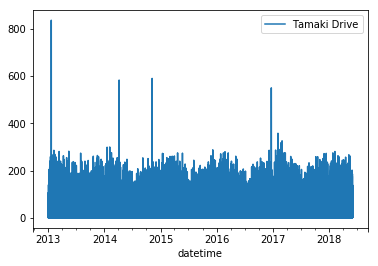

In [36]:
Tamaki.plot()

there seems to be a few pretty large outliers, we're going to try and filter these out

### getting rid of the outliers using a median filter 

In [37]:
utils.median_filter?

Signature: utils.median_filter(df, varname=None, window=24, std=3)
Docstring:
A simple median filter, removes (i.e. replace by np.nan) observations that exceed N (default = 3) 
tandard deviation from the median over window of length P (default = 24) centered around 
each observation.

Parameters
----------
df : pandas.DataFrame
    The pandas.DataFrame containing the column to filter.
varname : string
    Column to filter in the pandas.DataFrame. No default. 
window : integer 
    Size of the window around each observation for the calculation 
    of the median and std. Default is 24 (time-steps).
std : integer 
    Threshold for the number of std around the median to replace 
    by `np.nan`. Default is 3 (greater / less or equal).

Returns
-------
dfc : pandas.Dataframe
    A copy of the pandas.DataFrame `df` with the new, filtered column `varname`
File:      ~/research/NIWA/Auckland_Cycling/code/utils.py
Type:      function


In [38]:
dfc = Tamaki.copy()

In [39]:
dfc.loc[:,'Tamaki Drive, Filtered'] = utils.median_filter(dfc, varname='Tamaki Drive')

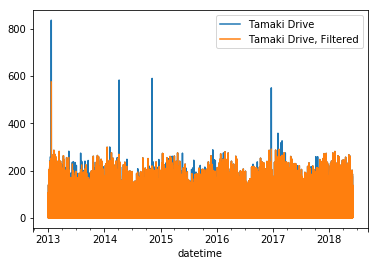

In [40]:
dfc.plot()

In [41]:
dfc.isnull().sum()

Tamaki Drive                6
Tamaki Drive, Filtered    229
dtype: int64

### plots the seasonal cycle (average and inter-quartile range)

In [42]:
seas_cycl = dfc.loc[:,'Tamaki Drive, Filtered'].rolling(window=30*24, center=True, min_periods=20).mean().groupby(dfc.index.dayofyear).mean()

In [43]:
q25 = dfc.loc[:,'Tamaki Drive, Filtered'].rolling(window=30*24, center=True, min_periods=20).mean().groupby(dfc.index.dayofyear).quantile(0.25)
q75 = dfc.loc[:,'Tamaki Drive, Filtered'].rolling(window=30*24, center=True, min_periods=20).mean().groupby(dfc.index.dayofyear).quantile(0.75)

the following cells build the ticks and tick labels for the seasonal cycle plot 

In [44]:
ndays_m = mdays.copy()

In [45]:
ndays_m[2] = 29

In [46]:
ndays_m = np.cumsum(ndays_m)

In [47]:
month_abbr = month_abbr[1:]

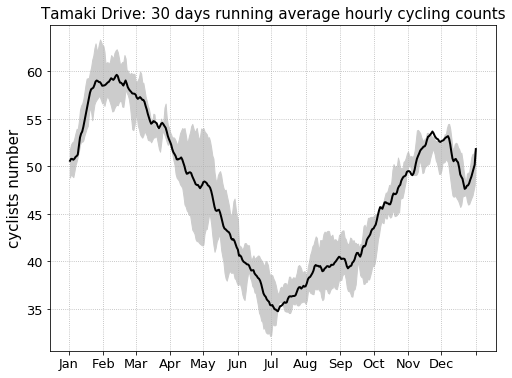

In [48]:
f, ax = plt.subplots(figsize=(8,6)) 

seas_cycl.plot(ax=ax, lw=2, color='k', legend=False)

ax.fill_between(seas_cycl.index, q25.values.ravel(), q75.values.ravel(), color='0.8')

ax.set_xticks(ndays_m)
ax.set_xticklabels(month_abbr)

ax.grid(ls=':')

ax.set_xlabel('', fontsize=15)

ax.set_ylabel('cyclists number', fontsize=15);

[l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
[l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()]

ax.set_title('Tamaki Drive: 30 days running average hourly cycling counts', fontsize=15)

for ext in ['png','jpeg','pdf']: 
    f.savefig(f'../figures/paper/seasonal_cycle.{ext}', dpi=200)

### cyclists per day of week and hour of the day 

In [49]:
hour_week = dfc.loc[:,['Tamaki Drive, Filtered']].copy()

In [50]:
hour_week.loc[:,'day_of_week'] = hour_week.index.dayofweek
hour_week.loc[:,'hour'] = hour_week.index.hour

In [51]:
hour_week = hour_week.groupby(['day_of_week','hour']).mean().unstack()

In [52]:
hour_week.columns = hour_week.columns.droplevel(0)

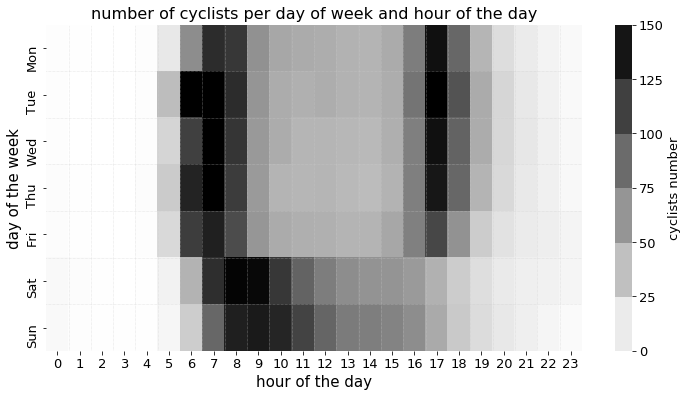

In [53]:
f, ax = plt.subplots(figsize=(12,6))

sns.heatmap(hour_week, ax = ax, cmap=plt.cm.gray_r, vmax=150, cbar_kws={'boundaries':np.arange(0,160,25)})

cbax = f.axes[1]
[l.set_fontsize(13) for l in cbax.yaxis.get_ticklabels()]
cbax.set_ylabel('cyclists number', fontsize=13)

[ax.axhline(x, ls=':', lw=0.5, color='0.8') for x in np.arange(1, 7)]
[ax.axvline(x, ls=':', lw=0.5, color='0.8') for x in np.arange(1, 24)];

ax.set_title('number of cyclists per day of week and hour of the day', fontsize=16)

[l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
[l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()]

ax.set_xlabel('hour of the day', fontsize=15)
ax.set_ylabel('day of the week', fontsize=15)
ax.set_yticklabels(day_abbr[0:7]);

for ext in ['png','jpeg','pdf']: 
    f.savefig(f'../figures/paper/cyclists_dayofweek_hourofday.{ext}', dpi=200)

### looking at week days versus week-ends 

In [54]:
weekdays = Tamaki.loc[Tamaki.index.weekday_name.isin(['Monday','Tuesday','Wednesday','Thursday','Friday'])]
weekends = Tamaki.loc[Tamaki.index.weekday_name.isin(['Sunday','Saturday'])]

In [55]:
summary_hour_weekdays = weekdays.groupby(weekdays.index.hour).describe()
summary_hour_weekends = weekends.groupby(weekends.index.hour).describe()

In [56]:
summary_hour_weekdays.columns = summary_hour_weekdays.columns.droplevel(0)

In [57]:
summary_hour_weekends.columns = summary_hour_weekends.columns.droplevel(0)

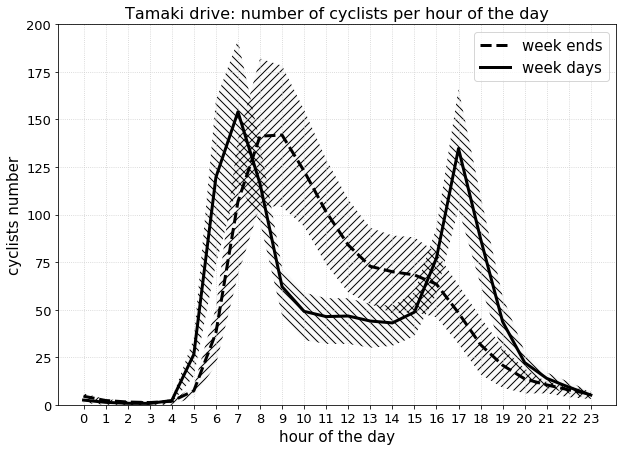

In [58]:
f, ax = plt.subplots(figsize=(10,7))

ax.plot(summary_hour_weekends.index, summary_hour_weekends.loc[:,'mean'], color='k', label='week ends', ls='--', lw=3)

ax.fill_between(summary_hour_weekends.index, summary_hour_weekends.loc[:,'25%'], \
                summary_hour_weekends.loc[:,'75%'], hatch='///', facecolor='0.8', alpha=0.1)

ax.set_xticks(range(24));

ax.grid(ls=':', color='0.8')

# ax.set_title('week-ends', fontsize=16)

ax.plot(summary_hour_weekdays.index, summary_hour_weekdays.loc[:,'mean'], color='k', label='week days', lw=3)

ax.fill_between(summary_hour_weekdays.index, summary_hour_weekdays.loc[:,'25%'], \
                summary_hour_weekdays.loc[:,'75%'], hatch='\\\\\\', facecolor='0.8', alpha=0.1)

ax.legend(loc=1 , fontsize=15)

ax.set_xticks(range(24));

ax.grid(ls=':', color='0.8')

ax.set_ylim([0, 200])

ax.set_xlabel('hour of the day', fontsize=15)

ax.set_ylabel('cyclists number', fontsize=15);

[l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
[l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()]

ax.set_title('Tamaki drive: number of cyclists per hour of the day', fontsize=16)

for ext in ['png','jpeg','pdf']: 
    f.savefig(f'../figures/paper/daily_cycle.{ext}', dpi=200)

### calculates the daily totals from the hourly data 

In [59]:
data = dfc.loc['2013':,['Tamaki Drive, Filtered']].resample('1D').sum()

### plots the time series 

We are separating the time-series into a **training set** (the period 2013 to 2016 included, i.e. 1461 days) and a **test set** (the period ranging from the 1st January 2017 to the 1st of June 2018, i.e. 517 days). The model will be fitted on the training set, and evaluated on the test set (out of sample prediction), to ensure a fair evaluation of the performance of the model. The grey vertical bar on the figure below marks the separation between the training and test set. 

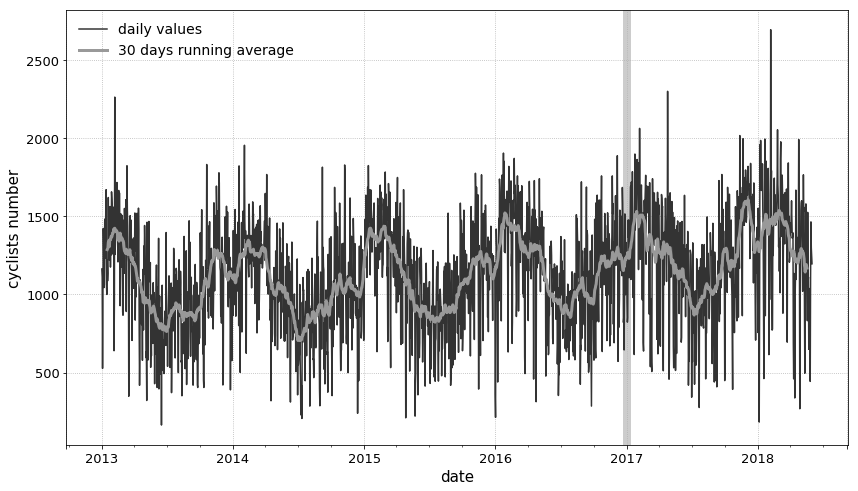

In [60]:
f, ax = plt.subplots(figsize=(14,8))

data.plot(ax=ax, color='0.2')

data.rolling(window=30, center=True).mean().plot(ax=ax, ls='-', lw=3, color='0.6')

ax.grid(ls=':')
ax.legend(['daily values','30 days running average'], frameon=False, fontsize=14)

[l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
[l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()]

ax.set_xlabel('date', fontsize=15)

ax.set_ylabel('cyclists number', fontsize=15);

ax.axvline('2017', color='0.8', lw=8, zorder=-1)

for ext in ['png','jpeg','pdf']: 
    f.savefig(f'../figures/paper/cycling_counts_Tamaki_drive.{ext}', dpi=200)

### creates a pandas dataframe holding the dates of the holidays (both national holidays and the Auckland regions' specific holidays)

see [holiday](https://github.com/dr-prodigy/python-holidays)

In [61]:
holidays_df = pd.DataFrame([], columns = ['ds','holiday'])

In [62]:
ldates = []
lnames = []
for date, name in sorted(holidays.NZ(prov='AUK', years=np.arange(2013, 2018 + 1)).items()):
    ldates.append(date)
    lnames.append(name)

In [63]:
ldates = np.array(ldates)
lnames = np.array(lnames)

In [64]:
holidays_df.loc[:,'ds'] = ldates

In [65]:
holidays_df.loc[:,'holiday'] = lnames

In [66]:
holidays_df.holiday.unique()

array(["New Year's Day", "Day after New Year's Day",
       'Auckland Anniversary Day', 'Waitangi Day', 'Good Friday',
       'Easter Monday', 'Anzac Day', "Queen's Birthday", 'Labour Day',
       'Christmas Day', 'Boxing Day', 'Anzac Day (Observed)',
       'Boxing Day (Observed)', "Day after New Year's Day (Observed)",
       'Waitangi Day (Observed)', 'Christmas Day (Observed)',
       "New Year's Day (Observed)"], dtype=object)

we conflate the actual holidays and the 'observed' ones to reduce the number of categories

In [67]:
holidays_df.loc[:,'holiday'] = holidays_df.loc[:,'holiday'].apply(lambda x : x.replace(' (Observed)',''))

In [68]:
holidays_df.holiday.unique()

array(["New Year's Day", "Day after New Year's Day",
       'Auckland Anniversary Day', 'Waitangi Day', 'Good Friday',
       'Easter Monday', 'Anzac Day', "Queen's Birthday", 'Labour Day',
       'Christmas Day', 'Boxing Day'], dtype=object)

### prepares the cycling count ndata for ingesting in fbprophet

In [69]:
data = data.rename({'Tamaki Drive, Filtered':'y'}, axis=1)

In [70]:
data.head()

,y
datetime,
2013-01-01,1163.0
2013-01-02,1112.0
2013-01-03,527.0
2013-01-04,1045.0
2013-01-05,1422.0


### Splits the data into a training and test set, and returns these data frames in a format **fbprophet** can understand 

In [71]:
data_train, data_test = utils.prepare_data(data, 2017)

In [72]:
data_train.tail()

,ds,y
1456,2016-12-27,1515.0
1457,2016-12-28,998.0
1458,2016-12-29,999.0
1459,2016-12-30,1333.0
1460,2016-12-31,1239.0


In [73]:
data_test.head()

,ds,y
0,2017-01-01,1245.0
1,2017-01-02,956.0
2,2017-01-03,823.0
3,2017-01-04,853.0
4,2017-01-05,1476.0


### Instantiate, then fit the model to the training data 

The first step in **fbprophet** is to instantiate the model, it is there that you can set the `prior scales` for each component of your time-series, as well as the number of Fourier series to use to model the cyclic components.   

A general rule is that larger prior scales and larger number of Fourier series will make the model more flexible, but at the potential cost of generalisation: i.e. the model might [overfit](https://en.wikipedia.org/wiki/Overfitting), learning the noise (rather than the signal) in the training data, but 
    giving poor results when applied to yet unseen data (the test data)... setting these [hyperparameters](https://en.wikipedia.org/wiki/Hyperparameter_(machine_learning)) can be more an art than a science ... 

In [74]:
m = Prophet(mcmc_samples=300, holidays=holidays_df, holidays_prior_scale=0.25, changepoint_prior_scale=0.01, seasonality_mode='multiplicative', \
            yearly_seasonality=10, \
            weekly_seasonality=True, \
            daily_seasonality=False)

In [75]:
m.fit(data_train)

/Users/nicolasf/anaconda3/envs/PANGEO/lib/python3.6/site-packages/pystan/misc.py:456: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if "chain_id" in inspect.getargspec(init).args:


### make the `future` dataframe 

In [76]:
future = m.make_future_dataframe(periods=len(data_test), freq='1D')

In [77]:
future.head()

,ds
0,2013-01-01
1,2013-01-02
2,2013-01-03
3,2013-01-04
4,2013-01-05


In [78]:
future.tail()

,ds
1973,2018-05-28
1974,2018-05-29
1975,2018-05-30
1976,2018-05-31
1977,2018-06-01


### forecast

In [79]:
forecast = m.predict(future)

### plots the `components` of the forecast (trend + cyclic component [yearly seasonality, weekly seasonality] and effects of the holidays at this stage)

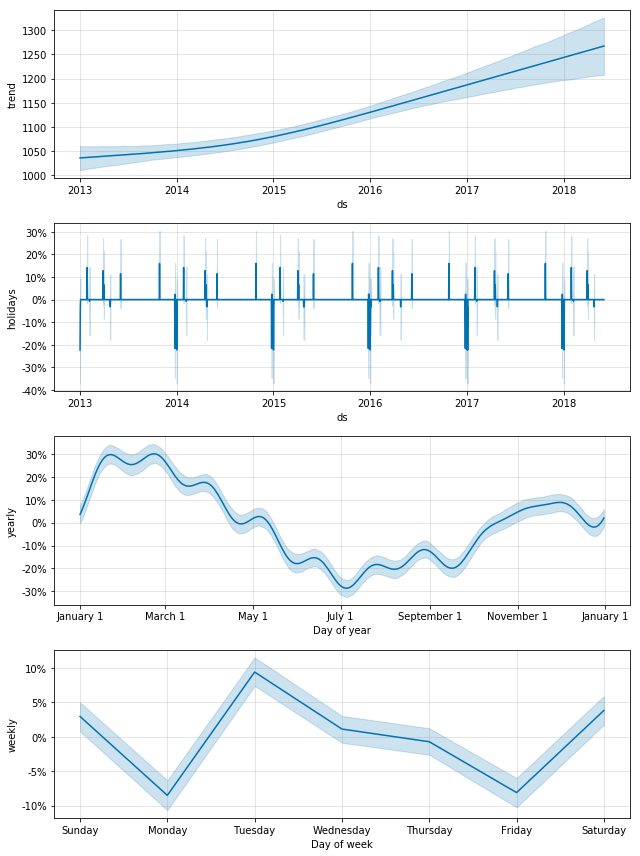

In [80]:
f = m.plot_components(forecast)

### put it all together with the actual observations 

In [81]:
utils.make_verif?

Signature: utils.make_verif(forecast, data_train, data_test)
Docstring:
Put together the forecast (coming from fbprophet) 
and the overved data, and set the index to be a proper datetime index, 
for plotting

Parameters
----------
forecast : pandas.DataFrame 
    The pandas.DataFrame coming from the `forecast` method of a fbprophet 
    model. 

data_train : pandas.DataFrame
    The training set, pandas.DataFrame

data_test : pandas.DataFrame
    The training set, pandas.DataFrame

Returns
-------
forecast : 
    The forecast DataFrane including the original observed data.
File:      ~/research/NIWA/Auckland_Cycling/code/utils.py
Type:      function


In [82]:
verif = utils.make_verif(forecast, data_train, data_test)

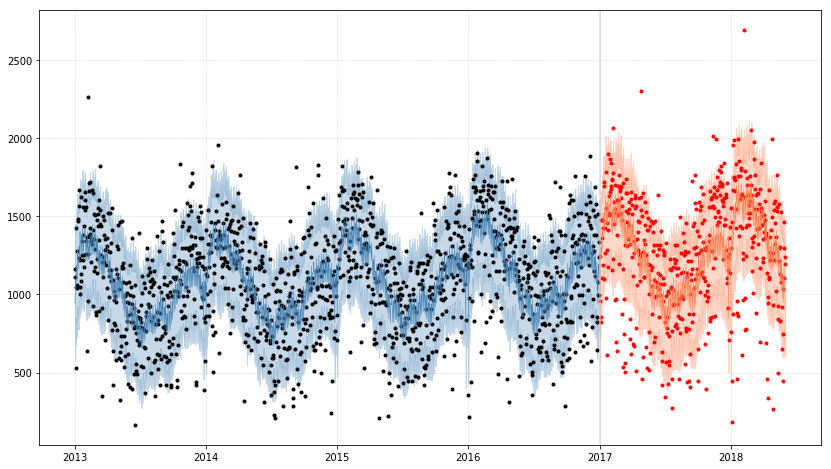

In [83]:
f = utils.plot_verif(verif)

### scatter plot, marginal distribution and correlation between observations and modelled / predicted values 

#### train set 

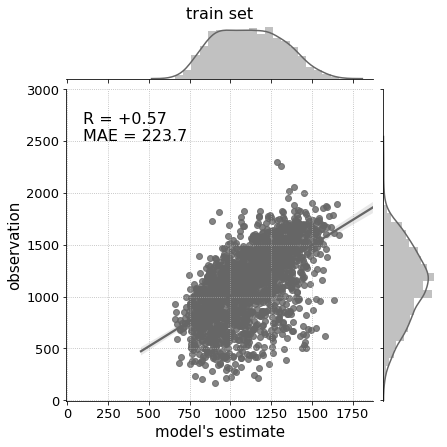

In [84]:
utils.plot_joint_plot(verif.loc[:'2017',:], title='train set', fname='train_set_joint_plot_no_climate')

### test set 

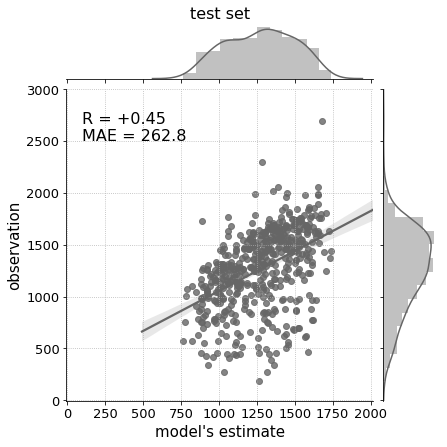

In [85]:
utils.plot_joint_plot(verif.loc['2017':,:], title='test set', fname='test_set_joint_plot_no_climate')

In [86]:
verif.loc['2017':,['y','yhat']].corr()

,y,yhat
y,1.000000,0.454109
yhat,0.454109,1.000000


### Mean Absolute Error (in number of cyclists)

In [87]:
MAE(verif.loc['2017':,'y'].values, verif.loc['2017':,'yhat'].values)

262.78266257402595

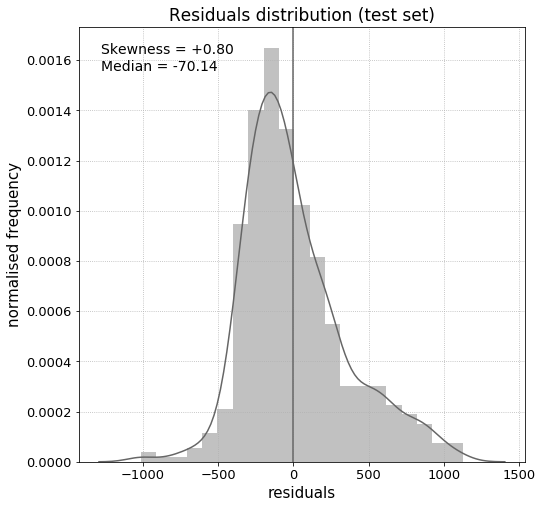

In [88]:
f, ax = plt.subplots(figsize=(8,8))
sns.distplot((verif.loc['2017':,'yhat'] - verif.loc['2017':,'y']), ax=ax, color='0.4')
ax.grid(ls=':')
ax.set_xlabel('residuals', fontsize=15)
ax.set_ylabel("normalised frequency", fontsize=15)
ax.grid(ls=':')

[l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
[l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()];

ax.text(0.05, 0.9, "Skewness = {:+4.2f}\nMedian = {:+4.2f}".\
        format(skew(verif.loc['2017':,'yhat'] - verif.loc['2017':,'y']), (verif.loc['2017':,'yhat'] - verif.loc['2017':,'y']).median()), \
        fontsize=14, transform=ax.transAxes)

ax.axvline(0, color='0.4')

ax.set_title('Residuals distribution (test set)', fontsize=17)

for ext in ['png','jpeg','pdf']: 
    f.savefig(f'../figures/paper/residuals_distribution_test_set_no_climate.{ext}', dpi=200)

## incorporating the effects of weather conditions

Now we add daytime (i.e. 6 AM to 9 PM) averaged temperature, rainfall, sunshine fraction and windspeed as **extra regressors** in the fbprophet model 

#### temperature 

In [89]:
temp = pd.read_csv('../data/weather/hourly/commute/temp_day.csv', index_col=0, parse_dates=True)

In [90]:
temp = temp.loc[:,['Tmin(C)']]

In [91]:
temp.columns = ['temp']

In [92]:
temp.head()

,temp
2012-01-01,19.807143
2012-01-02,18.000000
2012-01-03,19.335714
2012-01-04,19.307143
2012-01-05,19.978571


#### rainfall 

In [93]:
rain = pd.read_csv('../data/weather/hourly/commute/rain_day.csv', index_col=0, parse_dates=True)

In [94]:
rain = rain.loc[:,['Amount(mm)']]

In [95]:
rain.columns = ['rain']

In [96]:
rain.head()

,rain
2012-01-01,0.000000
2012-01-02,0.000000
2012-01-03,0.028571
2012-01-04,0.185714
2012-01-05,0.014286


#### sunshine fraction 

In [97]:
sun = pd.read_csv('../data/weather/hourly/commute/sun_day.csv', index_col=0, parse_dates=True)

In [98]:
sun.columns = ['sun']

In [99]:
sun.head()

,sun
2012-01-01,0.078571
2012-01-02,0.128571
2012-01-03,0.321429
2012-01-04,0.128571
2012-01-05,0.378571


#### wind 

In [100]:
wind = pd.read_csv('../data/weather/hourly/commute/wind_day.csv', index_col=0, parse_dates=True)

In [101]:
wind = wind.loc[:,['Speed(m/s)']]

In [102]:
wind.columns = ['wind']

In [103]:
wind.head()

,wind
2011-01-01,8.464286
2011-01-02,3.857143
2011-01-03,3.871429
2011-01-04,2.392857
2011-01-05,6.621429


### restrict to the available period 

In [104]:
temp = temp.loc['2013':'2018-06-01',:]

In [105]:
rain = rain.loc['2013':'2018-06-01',:]

In [106]:
sun = sun.loc['2013':'2018-06-01',:]

In [107]:
wind = wind.loc['2013':'2018-06-01',:]

### interpolate so that there are no missing values 

In [108]:
temp = temp.interpolate(method='linear')

In [109]:
rain = rain.interpolate(method='linear')

In [110]:
sun = sun.interpolate(method='linear')

In [111]:
wind = wind.interpolate(method='linear')

### adds the climate regressors to the data 

In [112]:
data_with_regressors = utils.add_regressor(data, temp, varname='temp')

In [113]:
data_with_regressors = utils.add_regressor(data_with_regressors, rain, varname='rain')

In [114]:
data_with_regressors = utils.add_regressor(data_with_regressors, sun, varname='sun')

In [115]:
data_with_regressors = utils.add_regressor(data_with_regressors, wind, varname='wind')

In [116]:
data_with_regressors.head()

,y,temp,rain,sun,wind
datetime,,,,,
2013-01-01,1163.0,20.000000,0.000000,0.950000,6.100000
2013-01-02,1112.0,20.342857,0.000000,0.535714,4.428571
2013-01-03,527.0,16.278571,0.228571,0.014286,4.728571
2013-01-04,1045.0,17.635714,0.000000,0.742857,8.978571
2013-01-05,1422.0,19.592857,0.000000,0.964286,6.185714


In [117]:
data_with_regressors.tail()

,y,temp,rain,sun,wind
datetime,,,,,
2018-05-28,1107.0,8.750000,0.0,0.271429,3.200000
2018-05-29,1464.0,7.764286,0.0,0.671429,2.571429
2018-05-30,1298.0,7.614286,0.0,0.621429,2.378571
2018-05-31,1239.0,8.192857,0.0,0.678571,2.057143
2018-06-01,1196.0,9.085714,0.0,0.635714,2.178571


### prepare the data and subsets (train and test set)

In [118]:
data_train, data_test = utils.prepare_data(data_with_regressors, 2017)

### we first instantiates a new fbprophet model, using the exact same prior scales and parameters as before 

In [119]:
m = Prophet(mcmc_samples=300, holidays=holidays_df, holidays_prior_scale=0.25, changepoint_prior_scale=0.01, seasonality_mode='multiplicative', \
            yearly_seasonality=10, \
            weekly_seasonality=True, \
            daily_seasonality=False)

Then we add the **extra-regressors** to the model using the `add_regressor` method

In [120]:
m.add_regressor('temp', prior_scale=0.5, mode='multiplicative')
m.add_regressor('rain', prior_scale=0.5, mode='multiplicative')
m.add_regressor('sun', prior_scale=0.5, mode='multiplicative')
m.add_regressor('wind', prior_scale=0.5, mode='multiplicative')

fit the new model

In [121]:
m.fit(data_train)

/Users/nicolasf/anaconda3/envs/PANGEO/lib/python3.6/site-packages/pystan/misc.py:456: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if "chain_id" in inspect.getargspec(init).args:


make the future DataFrame

In [122]:
future = m.make_future_dataframe(periods=len(data_test), freq='1D')

add the extra-regressors observed over the `future` DataFrame period 

In [123]:
futures = utils.add_regressor_to_future(future, [temp, rain, sun, wind])

the `future` DataFrame now includes the temperature, rainfall, sunshine fraction and wind speed as external (extra) regressors

In [124]:
futures.head()

,ds,temp,rain,sun,wind
0,2013-01-01,20.000000,0.000000,0.950000,6.100000
1,2013-01-02,20.342857,0.000000,0.535714,4.428571
2,2013-01-03,16.278571,0.228571,0.014286,4.728571
3,2013-01-04,17.635714,0.000000,0.742857,8.978571
4,2013-01-05,19.592857,0.000000,0.964286,6.185714


forecast using the extra-regressors as predictors

In [125]:
forecast = m.predict(futures)

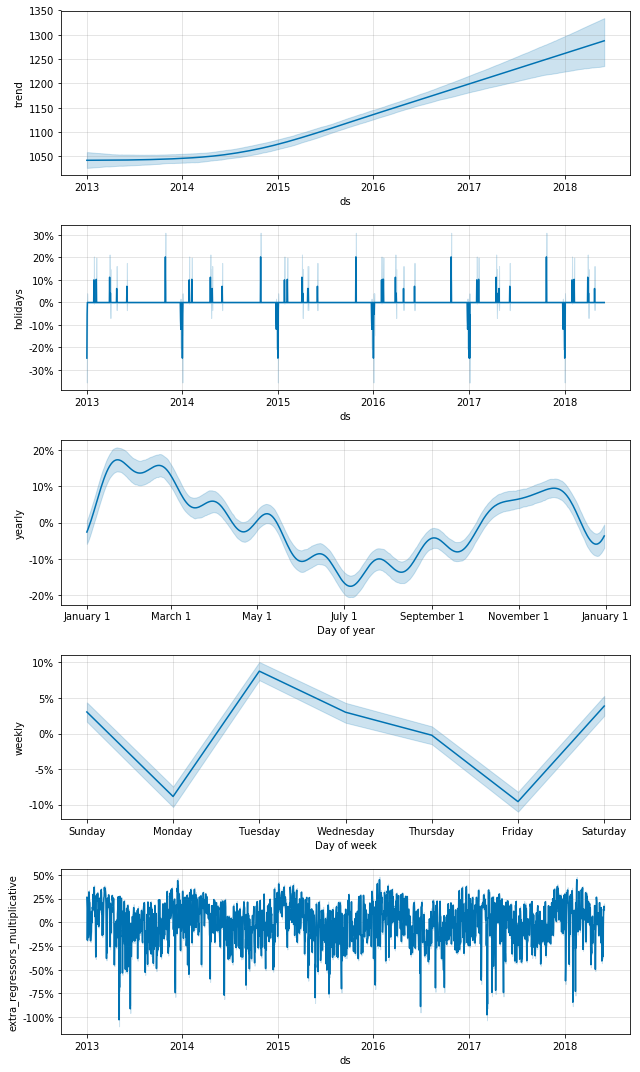

In [126]:
f = m.plot_components(forecast)

### make the `verif` pandas.DataFrame

In [127]:
verif = utils.make_verif(forecast, data_train, data_test)

In [128]:
verif.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Anzac Day,Anzac Day_lower,Anzac Day_upper,Auckland Anniversary Day,...,wind_lower,wind_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat,y
ds,,,,,,,,,,,,,,,,,,,,,
2013-01-01,2013-01-01,1042.129875,856.275389,1368.432202,1026.595369,1058.785073,0.0,0.0,0.0,0.0,...,-0.046861,-0.041691,-0.026076,-0.058776,0.005417,0.0,0.0,0.0,1122.136303,1163.0
2013-01-02,2013-01-02,1042.132189,925.596958,1416.871693,1026.606935,1058.793180,0.0,0.0,0.0,0.0,...,0.023733,0.026676,-0.016240,-0.049679,0.015339,0.0,0.0,0.0,1163.094797,1112.0
2013-01-03,2013-01-03,1042.134503,597.858395,1079.772229,1026.619907,1058.801288,0.0,0.0,0.0,0.0,...,0.011990,0.013477,-0.005419,-0.038960,0.026963,0.0,0.0,0.0,838.031272,527.0
2013-01-04,2013-01-04,1042.136818,739.153878,1189.530155,1026.633821,1058.808421,0.0,0.0,0.0,0.0,...,-0.173507,-0.154366,0.006241,-0.026605,0.038885,0.0,0.0,0.0,973.420914,1045.0
2013-01-05,2013-01-05,1042.139132,1137.195734,1616.714158,1026.665742,1058.769659,0.0,0.0,0.0,0.0,...,-0.050632,-0.045046,0.018577,-0.013810,0.051820,0.0,0.0,0.0,1373.328059,1422.0


### clips the forecasts so that no value is negative (can't have a negative number of cyclists ! )

In [129]:
verif.loc[:,'yhat'] = verif.yhat.clip_lower(0)

In [130]:
verif.loc[:,'yhat_lower'] = verif.yhat_lower.clip_lower(0)

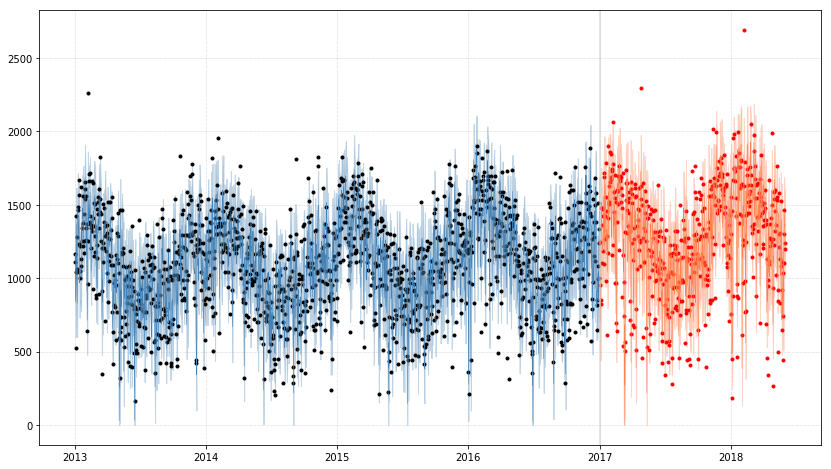

In [131]:
f =  utils.plot_verif(verif)

### scatter plot, marginal distribution and correlation between observations and modelled / predicted values

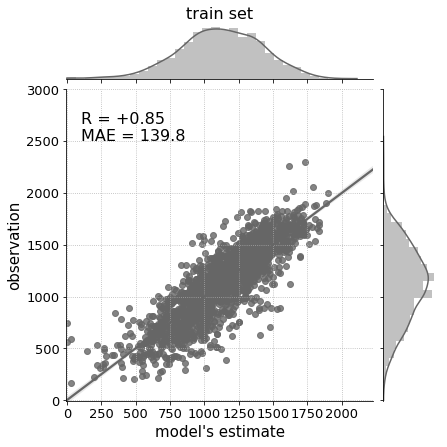

In [132]:
utils.plot_joint_plot(verif.loc[:'2017',:], title='train set', fname='train_set_joint_plot_climate')

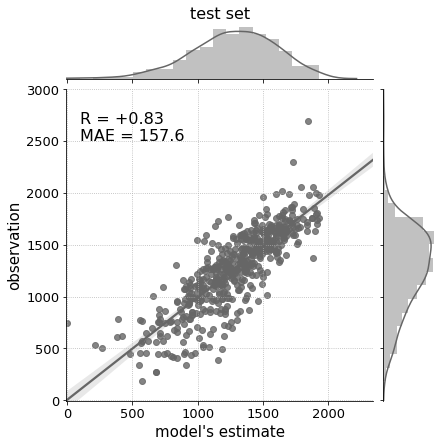

In [133]:
utils.plot_joint_plot(verif.loc['2017':,:], title='test set', fname='test_set_joint_plot_no_climate')

### residuals distributions (test set)

In [134]:
residuals = verif.loc['2017':,'yhat'] - verif.loc['2017':,'y']

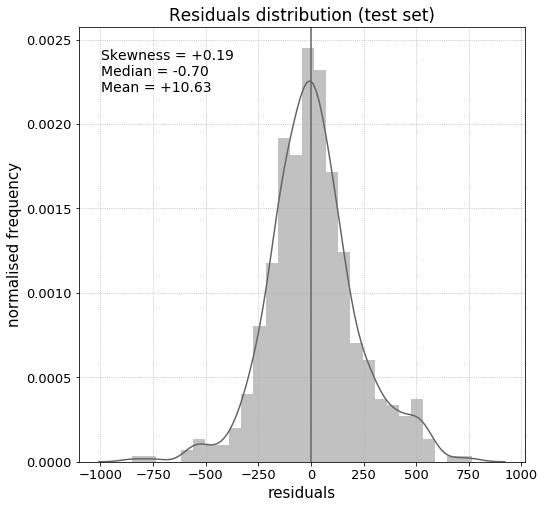

In [135]:
f, ax = plt.subplots(figsize=(8,8))
sns.distplot(residuals, ax=ax, color='0.4')
ax.grid(ls=':')
ax.set_xlabel('residuals', fontsize=15)
ax.set_ylabel("normalised frequency", fontsize=15)
ax.grid(ls=':')

[l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
[l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()];

ax.axvline(0, color='0.4')

ax.set_title('Residuals distribution (test set)', fontsize=17)

ax.text(0.05, 0.85, "Skewness = {:+4.2f}\nMedian = {:+4.2f}\nMean = {:+4.2f}".\
        format(skew(residuals), residuals.median(), residuals.mean()), \
        fontsize=14, transform=ax.transAxes)

for ext in ['png','jpeg','pdf']: 
    f.savefig(f'../figures/paper/residuals_distribution_test_set_climate.{ext}', dpi=200)

### plots the forecasts (`yhat`, dashed black line) and the observed values (`y`, solid grey line) in 6 months blocks

In [174]:
def make_plot_block(verif, start_date, end_date, ax=None): 
    
    df = verif.loc[start_date:end_date,:]

    df.loc[:,'yhat'].plot(lw=2, ax=ax, color='r', ls='-', label='forecasts')
    
    ax.fill_between(df.index, df.loc[:,'yhat_lower'], df.loc[:,'yhat_upper'], color='coral', alpha=0.3)
    
    df.loc[:,'y'].plot(lw=2, ax=ax, color='steelblue', ls='-', label='observations')

    ax.grid(ls=':')
    ax.legend(fontsize=15)
    [l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
    [l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()]
    ax.set_ylabel('cyclists number', fontsize=15)
    ax.set_xlabel('', fontsize=15)

    ax.set_title(f'{start_date} to {end_date}', fontsize=18)

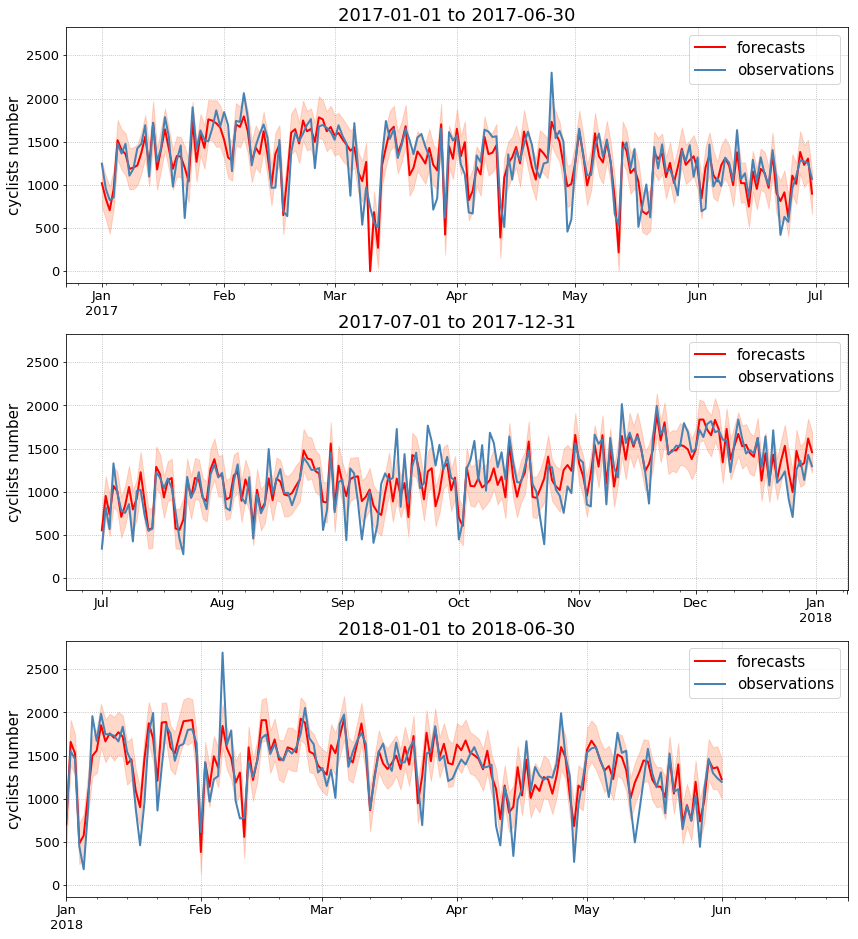

In [175]:
f, axes = plt.subplots(nrows=3, figsize=(14,16), sharey=True)

ax = axes[0]

make_plot_block(verif, '2017-01-01', '2017-06-30', ax=ax)

ax = axes[1]

make_plot_block(verif, '2017-07-01', '2017-12-31', ax=ax)

ax = axes[2]

make_plot_block(verif, '2018-01-01', '2018-06-30', ax=ax)

ax.set_xlim(['2018-01-01','2018-06-30'])

for ext in ['png','jpeg','pdf']: 
    f.savefig('../figures/paper/forecasts_obs_2017-08.{}'.format(ext), dpi=200)

### running correlations (over 90 days) between observed and modelled / predicted values

In [157]:
corr = verif.loc[:,['y','yhat']].rolling(window=90, center=True).corr().iloc[0::2,1]

In [158]:
corr.index = corr.index.droplevel(1)

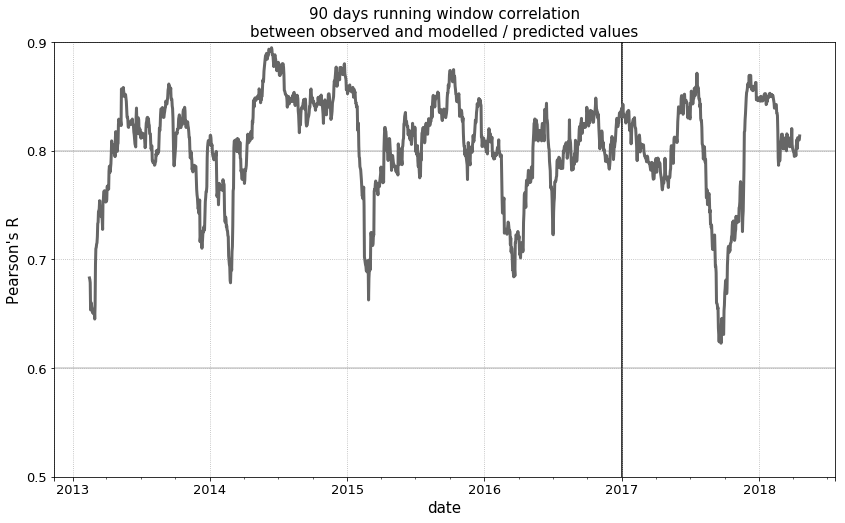

In [140]:
f, ax = plt.subplots(figsize=(14, 8))

corr.plot(ax=ax, lw=3, color='0.4')

ax.axhline(0.8, color='0.8', zorder=-1)
ax.axhline(0.6, color='0.8', zorder=-1)
ax.axvline('2017', color='k', zorder=-1)
ax.grid(ls=':')
ax.set_ylim([0.5, 0.9])
ax.set_xlabel('date', fontsize=15)
ax.set_ylabel("Pearson's R", fontsize=15)
ax.grid(ls=':')
[l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
[l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()]

ax.set_yticks(np.arange(0.5, 1., 0.1)); 

ax.set_title('90 days running window correlation\nbetween observed and modelled / predicted values', fontsize=15)

for ext in ['png','jpeg','pdf']: 
    f.savefig(f'../figures/paper/moving_corr.{ext}', dpi=200)

### correlation grouped by month, is there seasonality in the performance of the model ?

In [141]:
corr_season_test = verif.loc['2017':,['y','yhat']].groupby(verif.loc['2017':,:].index.month).corr()
corr_season_train = verif.loc[:'2017',['y','yhat']].groupby(verif.loc[:'2017',:].index.month).corr()
corr_season = verif.loc[:,['y','yhat']].groupby(verif.loc[:,:].index.month).corr()

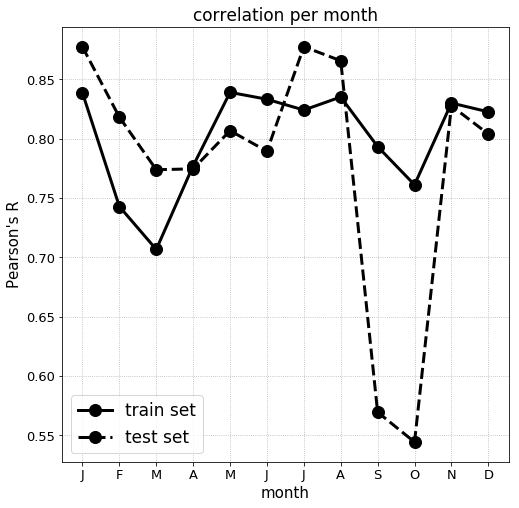

In [142]:
f, ax = plt.subplots(figsize=(8,8))
corr_season_train.xs('y', axis=0, level=1)['yhat'].plot(ax=ax, lw=3, marker='o', markersize=12, label='train set', ls='-', color='k')
corr_season_test.xs('y', axis=0, level=1)['yhat'].plot(ax=ax, lw=3, marker='o', markersize=12, label='test set', ls='--', color='k')
# corr_season.xs('y', axis=0, level=1)['yhat'].plot(ax=ax, lw=3, marker='o', markersize=12)

ax.legend(fontsize=17, loc=3)

ax.set_xticks(range(1, 13))
ax.set_xticklabels(list('JFMAMJJASOND'))
ax.set_xlabel('month', fontsize=15)
ax.set_ylabel("Pearson's R", fontsize=15)
ax.grid(ls=':')
[l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
[l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()]

ax.set_title('correlation per month', fontsize=17)

for ext in ['png','jpeg','pdf']: 
    f.savefig(f'../figures/paper/correlation_obs_pred_per_month.{ext}', dpi=200)

### plot the contribution of the different climate variables to the response variable (in percentage of the trend component, as we chose a multiplicative model)

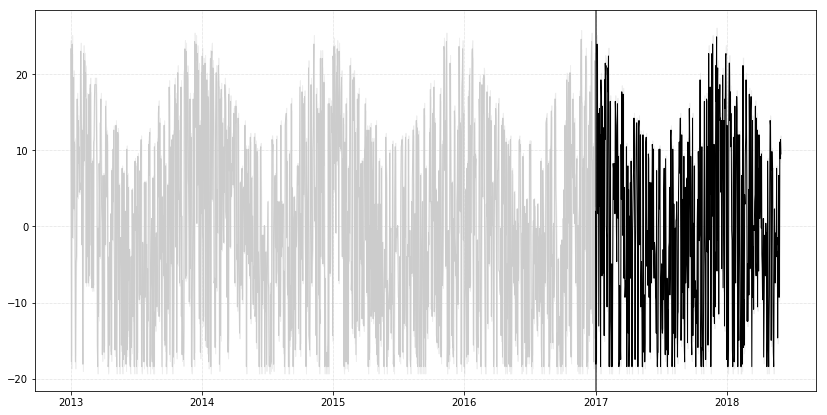

In [143]:
f  = utils.plot_verif_component(verif, component = 'sun')

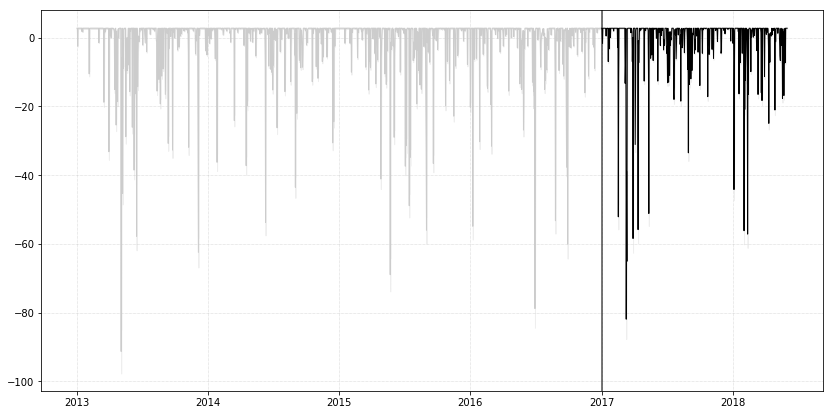

In [144]:
f  = utils.plot_verif_component(verif, component = 'rain')

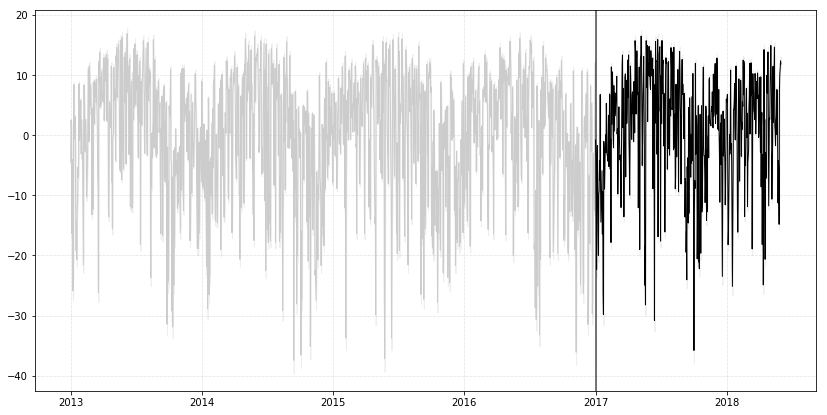

In [145]:
f  = utils.plot_verif_component(verif, component = 'wind')

### plots the combined contribution of the climate extra-regressors

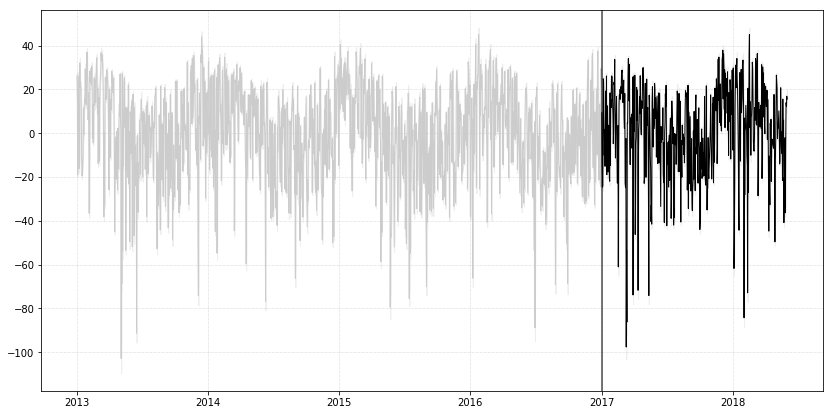

In [146]:
f = utils.plot_verif_component(verif, component = 'extra_regressors_multiplicative')